(data_container)=
# Using Data Containers

:::{post} Dec 16, 2021
:tags: posterior predictive, shared data 
:category: beginner
:author: Juan Martin Loyola, Kavya Jaiswal, Oriol Abril, Jesse Grabowski
:::

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm


print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.20.1


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = sum(map(ord, "Data Containers in PyMC"))
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.constrained_layout.use"] = True

## Introduction

After building the statistical model of your dreams, you're going to need to feed it some data. Data is typically introduced to a PyMC model in one of two ways. Some data is used as an exogenous input, called `X` in linear regression models, where `mu = X @ beta`. Other data are "observed" examples of the endogenous outputs of your model, called `y` in regression models, and is used as input to the likelihood function implied by your model. These data, either exogenous or endogenous, can be included in your model as wide variety of datatypes, including numpy `ndarrays`, pandas `Series` and `DataFrame`, and even pytensor `TensorVariables`. 

Although you can pass these "raw" datatypes to your PyMC model, the best way to introduce data into your model is to use {class}`pymc.Data` containers. These containers make it extremely easy to work with data in a PyMC model. They offer a range of benefits, including:

1. Visualization of data as a component of your probabilistic graph
2. Access to labeled dimensions for readability and accessibility
3. Support for swapping out data for out-of-sample prediction, interpolation/extrapolation, forecasting, etc.
4. All data will be stored in your {class}`arviz.InferenceData`, which is useful for plotting and reproducible workflows.

:::{important}
 Data containers are all mutable now{func}`pymc.Data`. [API ref](https://www.pymc.io/projects/docs/en/stable/api.html)
:::

## Using Data Containers for readability and reproducibility

The example shows some of the differences between using a data container and "raw" data. This first model shows how raw data, in this case a numpy arrays, can be directly provided to a PyMC model.

Initializing NUTS using jitter+adapt_diag...
/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/pytensor/link/c/cmodule.py:2959: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


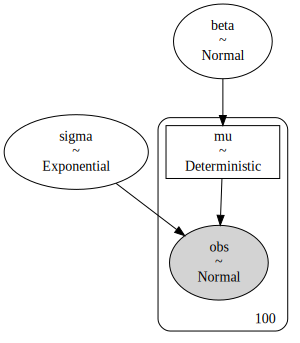

In [3]:
true_beta = 3
true_std = 5
n_obs = 100
x = rng.normal(size=n_obs)
y = rng.normal(loc=true_beta * x, scale=true_std, size=n_obs)

with pm.Model() as no_data_model:
    beta = pm.Normal(name="beta")
    mu = pm.Deterministic(name="mu", var=beta * x)
    sigma = pm.Exponential(name="sigma", lam=1)
    # procide the observed data (y) directly to a PyMC model
    obs = pm.Normal(name="obs", mu=mu, sigma=sigma, observed=y)
    idata = pm.sample(random_seed=RANDOM_SEED)

pm.model_to_graphviz(no_data_model)

Looking at the resulting computational graph, the `obs` node is shaded gray to indicate that it has observed data, in this case `y`. But the data itself is not shown on the graph, so there's no hint about what data has been observed. In addition, the `x` data doesn't appear in the graph anywhere, so it's not obvious that this model used exogenous data as an input.

Furthermore, inside `idata`, PyMC has automatically saved the observed (endogenous) `y` data, but not the exogenous `x` data. If we wanted to save this inference data for reuse, or to make it available as part of a reproducible research package, we would have to be sure to include the `x` data separately. 

xarray.Dataset is a dict-like container of labeled arrays with aligned dimensions.

In [4]:
idata.observed_data

<xarray.Dataset> Size: 2kB
Dimensions:    (obs_dim_0: 100)
Coordinates:
  * obs_dim_0  (obs_dim_0) int64 800B 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
Data variables:
    obs        (obs_dim_0) float64 800B -0.3966 -3.337 -7.844 ... -6.549 -0.8598
Attributes:
    created_at:                 2025-02-26T00:13:00.343582+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.20.1

In this next model, we create a {class}`pymc.Data` container to hold the observations, and pass this container to the `observed`. We also make a {class}`pymc.Data` container to hold the `x` data:

Because we used a {class}`pymc.Data` container, the data now appears in our probabilistic graph. It is downstream from `obs` (since the `obs` variable "causes" the data), shaded in gray (because it is observed), and has a special rounded square shape to emphasize that it is data. We also see that `x_data` has been added to the graph.

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


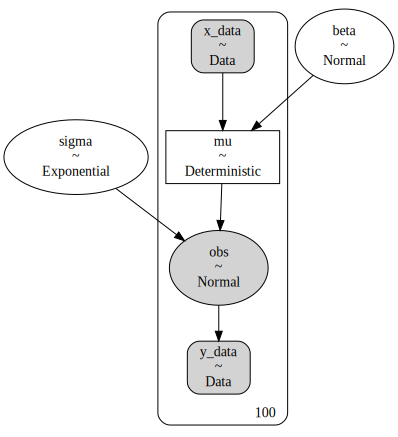

In [5]:
with pm.Model() as no_data_model:
    x_data = pm.Data(name="x_data", value=x)
    y_data = pm.Data(name="y_data", value=y)
    beta = pm.Normal(name="beta")
    mu = pm.Deterministic(name="mu", var=beta * x_data)
    sigma = pm.Exponential(name="sigma",  lam=1)
    obs = pm.Normal(name="obs", mu=mu, sigma=sigma, observed=y_data)
    idata = pm.sample(random_seed=RANDOM_SEED)

pm.model_to_graphviz(no_data_model)

In [6]:
# Finally, we can check the inference data to see that the `x` data has been stored there as well. It is now a complete summary of all information needed to reproduce our model.

idata.constant_data

<xarray.Dataset> Size: 3kB
Dimensions:       (x_data_dim_0: 100, y_data_dim_0: 100)
Coordinates:
  * x_data_dim_0  (x_data_dim_0) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
  * y_data_dim_0  (y_data_dim_0) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
Data variables:
    x_data        (x_data_dim_0) float64 800B -1.383 -0.2725 ... -1.745 -0.5087
    y_data        (y_data_dim_0) float64 800B -0.3966 -3.337 ... -6.549 -0.8598
Attributes:
    created_at:                 2025-02-26T00:13:02.633681+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.20.1

### Named dimensions with data containers

Named dimensions are another powerful benefit of working with data containers. Data containers allow users to keep track of dimensions (like dates or cities) and coordinates (such as the actual date times or city names) of multi-dimensional data. Both allow you to specify the dimension names and coordinates of random variables, instead of specifying the shapes of those random variables as numbers. Notice that in the previous probabilistic graphs, all of the nodes `x_data`, `mu`, `obs` and `y_data` were in a box with the number 100. A natural question for a reader to ask is, "100 what?". Dimensions and coordinates help organize models, variables, and data by answering exactly this question.

In the next example, we generate an artificial dataset of temperatures in 3 cities over 2 months. We will then use named dimensions and coordinates to improve the readability of the model code and the quality of the visualizations.

As noted above, {class}`pymc.Data` gives you the ability to give named labels to the dimensions of your data. This is done by passing a dictionary of `dimension: coordinate` key-value pairs to the `coords` argument of {class}`pymc.Model` when you create your model.

For more explanation about dimensions, coordinates and their big benefits, we encourage you to take a look at the {ref}`ArviZ documentation <arviz:xarray_for_arviz>`.

We will use a hierarchical model: it assumes a mean temperature for the European continent and models each city relative to the continent mean:

In [7]:
df_data = pd.DataFrame(columns=["date"]).set_index("date")
dates = pd.date_range(start="2020-05-01", end="2020-07-01")

for city, mu in {"Berlin": 15, "San Marino": 18, "Paris": 16}.items():
    df_data[city] = rng.normal(loc=mu, size=len(dates))

df_data.index = dates
df_data.index.name = "date"

print(df_data.head())

# The data has two dimensions: date and city
# The "coordinates" are the unique values that these dimensions can take
coords = {"date": df_data.index, "city": df_data.columns}

               Berlin  San Marino      Paris
date                                        
2020-05-01  15.401536   18.817801  16.836690
2020-05-02  13.575241   17.441153  14.407089
2020-05-03  14.808934   19.890369  15.616649
2020-05-04  16.071487   18.407539  15.396678
2020-05-05  15.505263   17.621143  16.723544


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [europe_mean_temp, city_offset, sigma]


/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


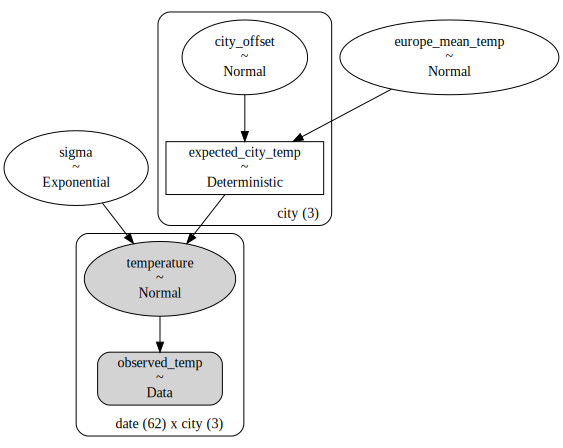

In [8]:
with pm.Model(coords=coords) as model:
    data = pm.Data(name="observed_temp", value=df_data, dims=("date", "city"))

    europe_mean = pm.Normal(name="europe_mean_temp", mu=15.0, sigma=3.0)
    city_offset = pm.Normal(name="city_offset", mu=0.0, sigma=3.0, dims="city")
    city_temperature = pm.Deterministic(
        name="expected_city_temp", var=europe_mean + city_offset, dims="city"
    )

    sigma = pm.Exponential(name="sigma", lam=1)
    pm.Normal(name="temperature", mu=city_temperature, sigma=sigma, observed=data, dims=("date", "city"))

    idata = pm.sample(
        random_seed=RANDOM_SEED,
    )

pm.model_to_graphviz(model)

Looking at the probabilistic graph implied by our model. Similar node (or groups of nodes) are grouped inside plates. The plates are labeled with the dimensions of each node. Now we see there are 3 cities and 62 dates. Each of the 3 cities has it's own offset, which, together with a group average, determines the estimated temperature. Finally, we see that our data is actually a 2d matrix. Adding labeled dimensions has greatly improved the presentation of our probabilistic model. 

In [9]:
# And we see that the model did remember the coords we gave it:
for k, v in model.coords.items():
    print(f"{k}: {v[:20]}")

# Coordinates are automatically stored into the {class}`arviz.InferenceData` object:
idata.posterior.coords

date: (Timestamp('2020-05-01 00:00:00'), Timestamp('2020-05-02 00:00:00'), Timestamp('2020-05-03 00:00:00'), Timestamp('2020-05-04 00:00:00'), Timestamp('2020-05-05 00:00:00'), Timestamp('2020-05-06 00:00:00'), Timestamp('2020-05-07 00:00:00'), Timestamp('2020-05-08 00:00:00'), Timestamp('2020-05-09 00:00:00'), Timestamp('2020-05-10 00:00:00'), Timestamp('2020-05-11 00:00:00'), Timestamp('2020-05-12 00:00:00'), Timestamp('2020-05-13 00:00:00'), Timestamp('2020-05-14 00:00:00'), Timestamp('2020-05-15 00:00:00'), Timestamp('2020-05-16 00:00:00'), Timestamp('2020-05-17 00:00:00'), Timestamp('2020-05-18 00:00:00'), Timestamp('2020-05-19 00:00:00'), Timestamp('2020-05-20 00:00:00'))
city: ('Berlin', 'San Marino', 'Paris')


Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * city     (city) <U10 120B 'Berlin' 'San Marino' 'Paris'

Coordinates are also used by `arviz` when making plots. Here we pass `legend=True` to `az.plot_trace` to automatically label the three cities in our trace plot.

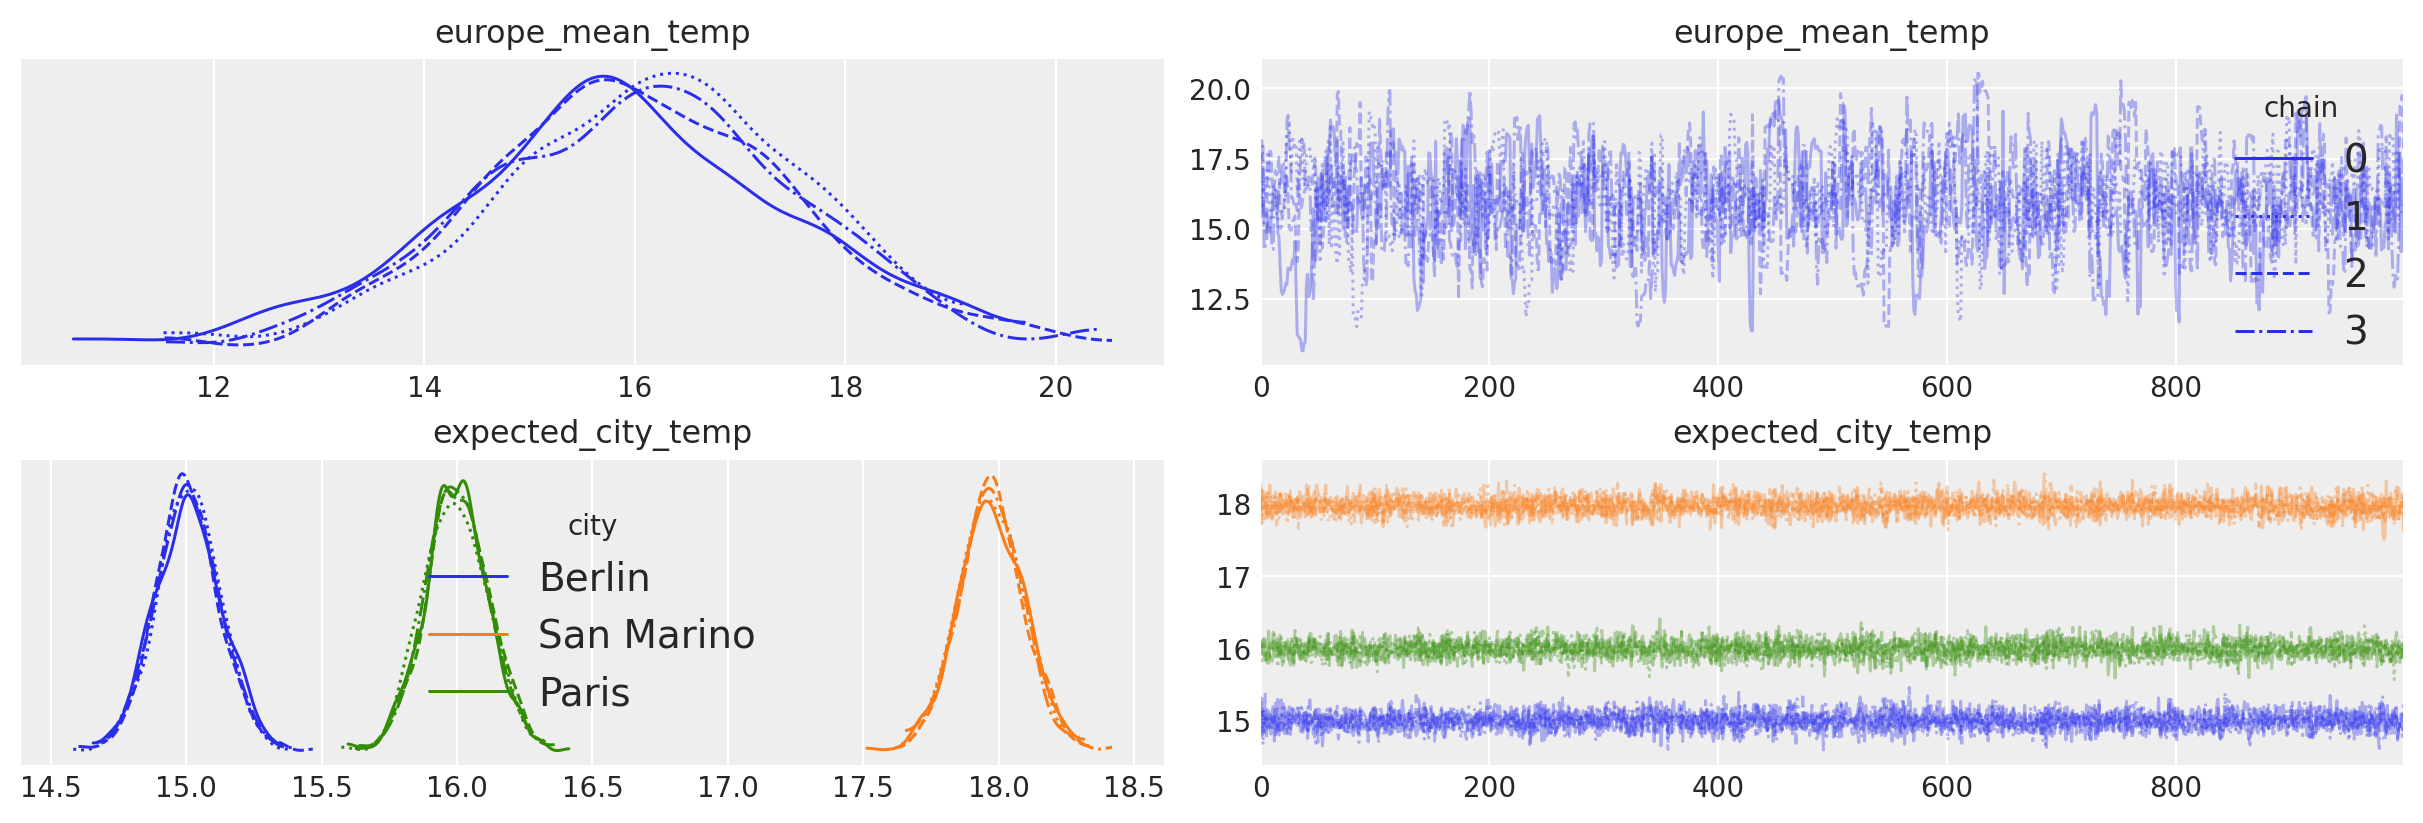

In [10]:
axes = az.plot_trace(idata, var_names=["europe_mean_temp", "expected_city_temp"], legend=True);

In [11]:
# When we use {class}`pymc.Data`, the data are internally represented as a pytensor {class}`pytensor.tensor.sharedvar.TensorSharedVariable`.
type(data)

pytensor.tensor.sharedvar.TensorSharedVariable

The values of all `pytensor` tensors can be checked using the {meth}`pytensor.graph.Variable.eval` method. To access the data, we can use the {class}`pymc.Model` object. All model variables, including data containers, can be accessed by indexing the model object itself with a variable name. Since this line:

```python
    data = pm.Data("observed_temp", df_data, dims=("date", "city"))
```

Gave the name "observed_temp" to the data, we can access it as follows: 

In [12]:
model["observed_temp"].eval()[:15]

array([[15.40153619, 18.81780064, 16.83668986],
       [13.57524128, 17.4411525 , 14.40708945],
       [14.80893441, 19.89036942, 15.61664911],
       [16.07148689, 18.40753876, 15.39667778],
       [15.50526329, 17.62114292, 16.72354378],
       [14.86774578, 16.91297071, 16.64398094],
       [15.39861564, 18.06957647, 16.8952898 ],
       [14.82344668, 17.8925678 , 18.13033425],
       [14.29595165, 18.18139386, 14.87228836],
       [13.7296701 , 18.6225866 , 15.67262894],
       [14.68800267, 17.48605691, 15.26520975],
       [14.62891834, 19.16219466, 16.71921201],
       [14.58253668, 17.09701213, 17.10149473],
       [14.39255946, 17.66357467, 15.68899804],
       [15.8653625 , 16.66259542, 16.69857121]])

## Using Data Containers to mutate data

In many cases, you will want the ability to switch out data between model runs. This arises when you want to fit a model to multiple datasets, if you are interested in out-of-sample prediction, and in many other applications.

### Using Data container variables to fit the same model to several datasets

We can use `Data` container variables in PyMC to fit the same model to several datasets without the need to recreate the model each time (which can be time consuming if the number of datasets is large). **Note, however, that the model will still be recompilied each time.** 

In the next example, we will generate 10 models with a single parameter, `mu`. Each model will have a dataset with a different number of observations, from 10 to 100. We will use this setup to explore the effect of data quantity on parameter recovery. 

In [13]:
# We generate 10 datasets
n_models = 10
obs_multiplier = 10

true_mu = [rng.random() for _ in range(n_models)]
observed_data = [mu + rng.normal(size=(i + 1) * obs_multiplier) for i, mu in enumerate(true_mu)]

with pm.Model() as model:
    data = pm.Data("data", observed_data[0])
    mu = pm.Normal("mu", 0, 10)
    pm.Normal("y", mu=mu, sigma=1, observed=data)

As we have shown before we can use the `eval` method to check our `Data` container values:  

In [14]:
model["data"].eval()

array([-0.10562792,  0.62102496,  1.48658991,  0.92295128,  0.43538261,
        0.73235925, -0.11983016,  0.89501808, -0.39242869,  1.4783441 ])

While `eval` can be used to check the values, {func}`pymc.set_data` is used to change them. Let's use the `Data` together with `pymc.set_data` to repeatedly fit the same model to multiple datasets. Note that it doesn't matter that each dataset has a different size!

In [15]:
# Generate one trace for each dataset
idatas = []
for data_vals in observed_data:
    with model:
        # Switch out the observed dataset
        pm.set_data({"data": data_vals})
        idatas.append(pm.sample(random_seed=RANDOM_SEED))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Arviz's {func}`arviz.plot_forest` allows you to pass a list of `idata`  objects with the same variables names. In this way, we can quickly visualize the different estimates from the 10 different datasets. We also use `matplotlib` to scatter the true parameter values on top of the `plot_forest`. We can see that as we go from 10 observations in model 1 to 100 observations in model 10, the estimates become increasing centered on the true value of mu, and the uncertainty around the estimate goes down.

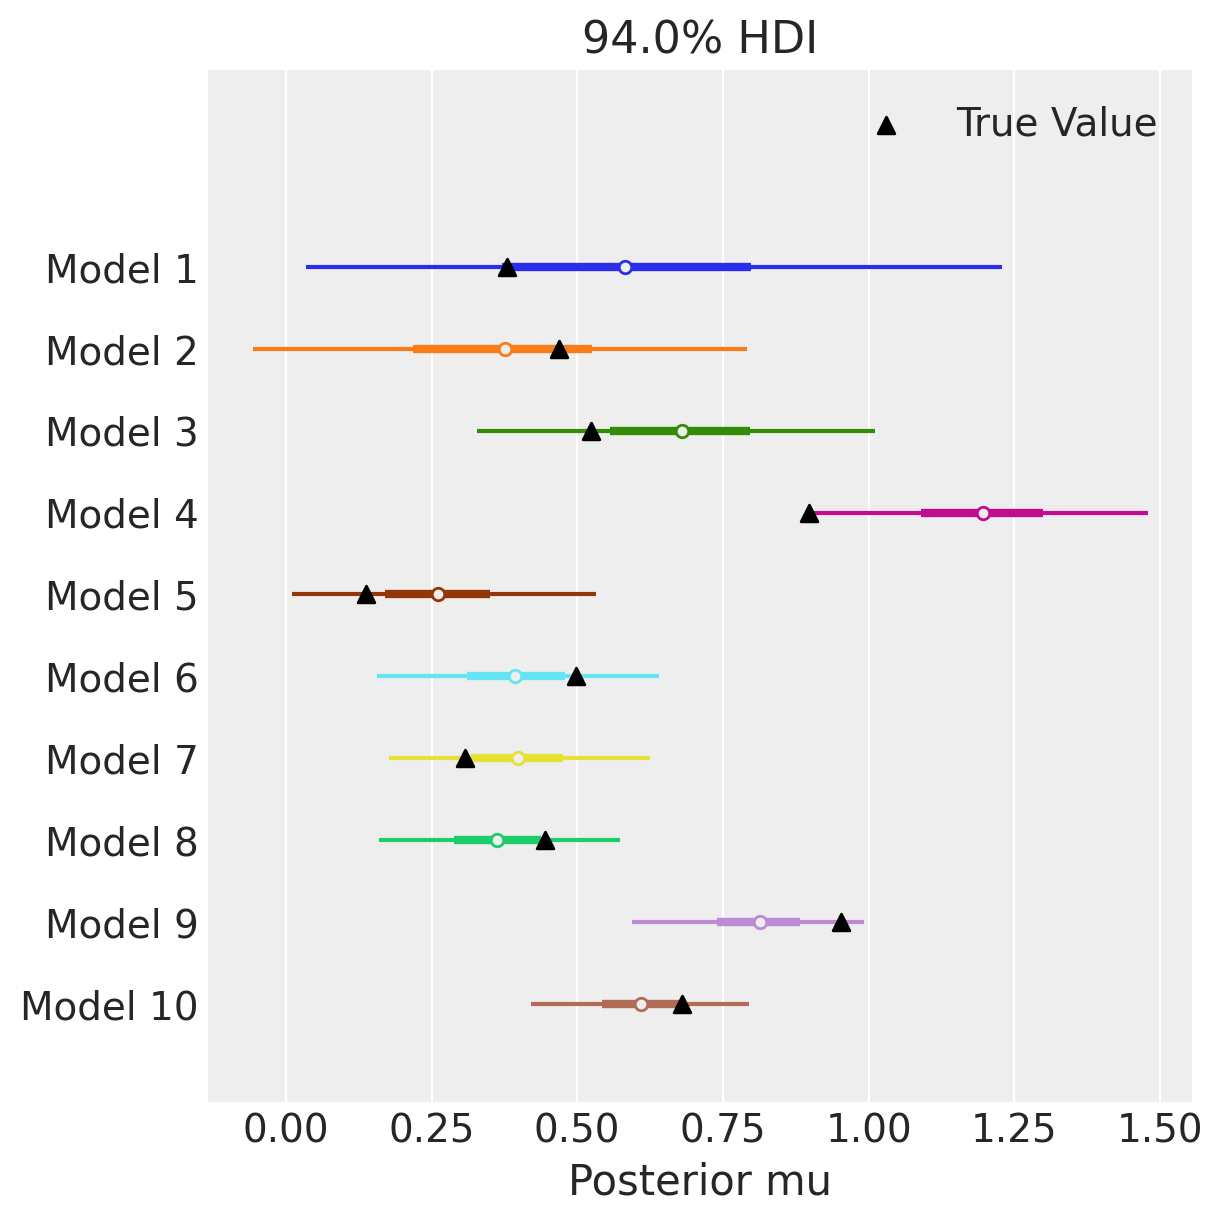

In [16]:
model_idx = np.arange(n_models, dtype="int")
axes = az.plot_forest(idatas, var_names=["mu"], combined=True, figsize=(6, 6), legend=False)

ax = axes[0]
y_vals = np.stack([ax.get_lines()[i].get_ydata() for i in np.arange(n_models)]).ravel()
ax.scatter(true_mu, y_vals[::-1], marker="^", color="k", zorder=100, label="True Value")
ax.set(yticklabels=[f"Model {i+1}" for i in model_idx[::-1]], xlabel="Posterior mu")
ax.legend()
plt.show()

## Applied Example: Using Data containers as input to a binomial GLM

A common task in machine learning is to predict values for unseen data, and the `Data` container variable is exactly what we need to do this. 

One small detail to pay attention to in this case is that the shapes of the input data (`x`) and output data (`obs`) must be the same. When we make out-of-sample predictions, we typically change only the input data, the shape of which may not be the same as the training observations. Naively changing only one will result in a shape error. There are two solutions:

1. Use a {class}`pymc.Data` for the `x` data and the `y` data, and use `pm.set_data` to change `y` to something of the same shape as the test inputs. 
2. Tell PyMC that the shape of the `obs` should always be the shape of the input data.

In the next model, we use option 2. This way, we don't need to pass dummy data to `y` every time we want to change `x`.

In [17]:
n_obs = 100
true_beta = 1.5
true_alpha = 0.25

x = rng.normal(size=n_obs)
true_p = 1 / (1 + np.exp(-(true_alpha + true_beta * x)))
y = rng.binomial(n=1, p=true_p)

In [18]:
with pm.Model() as logistic_model:
    x_data = pm.Data("x", x)
    y_data = pm.Data("y", y)

    alpha = pm.Normal("alpha")
    beta = pm.Normal("beta")

    p = pm.Deterministic("p", pm.math.sigmoid(alpha + beta * x_data))

    # Here is were we link the shapes of the inputs (x_data) and the observed variable
    # It will be the shape we tell it, rather than the (constant!) shape of y_data
    obs = pm.Bernoulli("obs", p=p, observed=y_data, shape=x_data.shape[0])

    # fit the model
    idata = pm.sample(random_seed=RANDOM_SEED)

    # Generate a counterfactual dataset using our model
    idata = pm.sample_posterior_predictive(
        idata, extend_inferencedata=True, random_seed=RANDOM_SEED
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

A common post-estimation diagnostic is to look at a posterior predictive plot, using {func}`arviz.plot_ppc`. This shows the distribution of data sampled from your model along side the observed data. If they look similar, we have some evidence that the model isn't so bad.

In this case, however, it can be difficult to interpret a posterior predictive plot. Since we're doing a logistic regression, observed values can only be zero or one. As a result, the posterior predictive graph has this tetris-block shape. What are we to make of it? Evidently our model produces more 1's than 0's, and the mean proportion matches the data. But there's also a lot of uncertainty in that proportion. What else can we say about the model's performance?  

<Axes: xlabel='obs'>

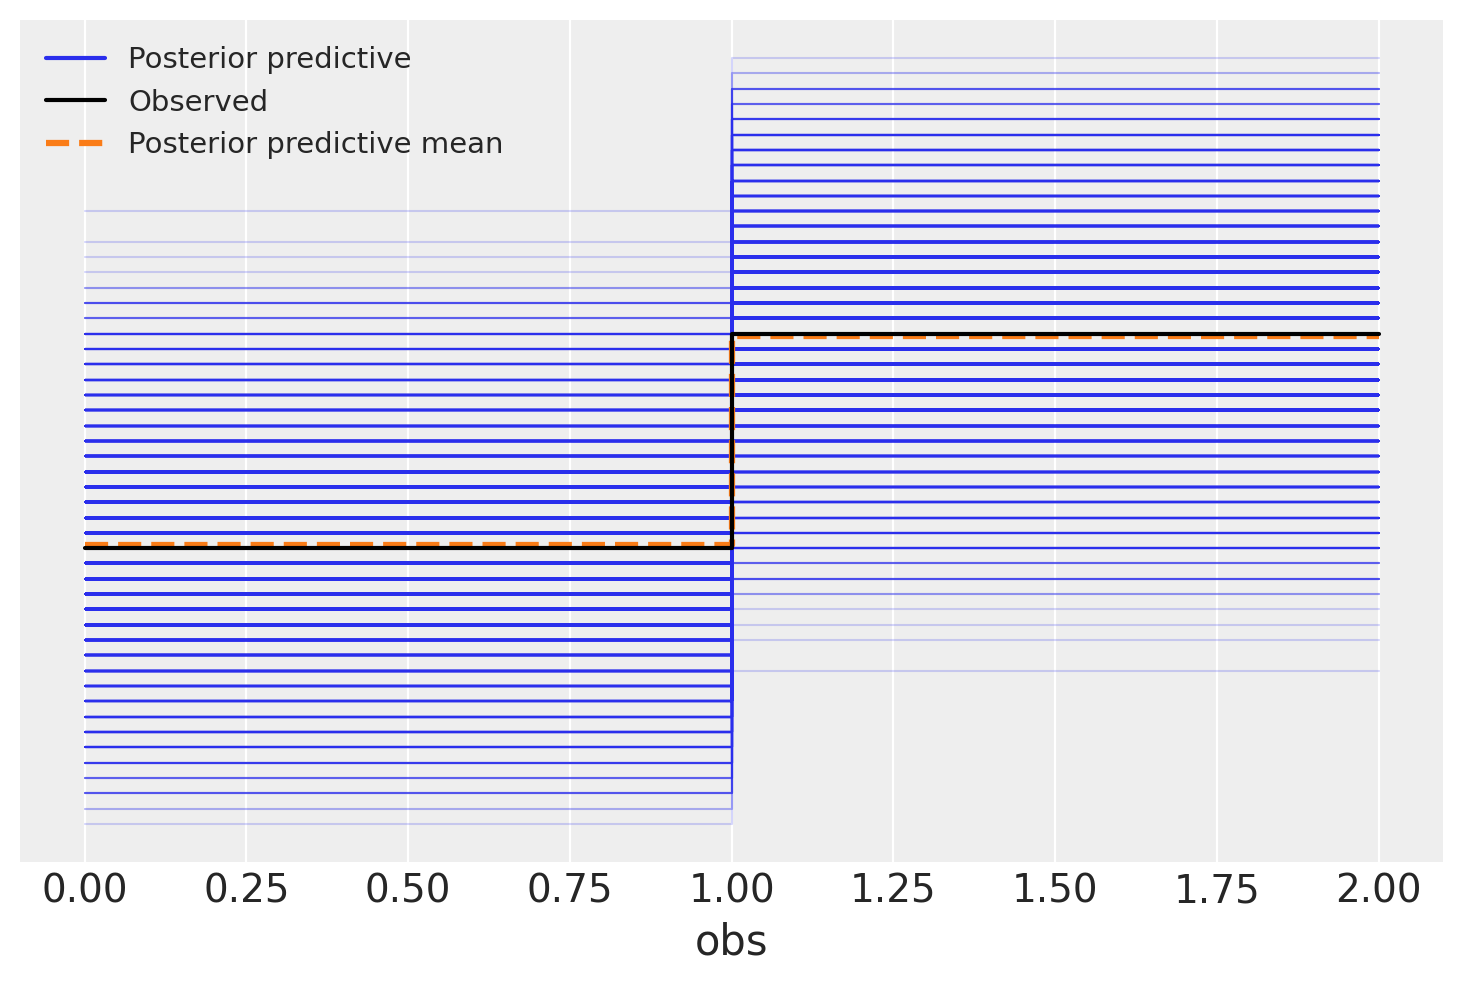

In [19]:
az.plot_ppc(idata)

Another graph we could make to see how our model is doing is to look at how the latent variable `p` evolves over the space of covariates. We expect some relationship between the covariate and the data, and our model encodes that relationship in the variable `p`. In this model, the only covariate is `x`. If the relationship between `x` and `y` is positive, we expect low `p` and lots of observed zeros where `x` is small, and high `p` and lots of observed ones where it is large.  

That's nice and all, but for plotting `x` is all jumbled up. Admittedly, we could just sort the values. But another way (that shows off how to use our `Data`!) is to pass an evenly spaced grid of `x` values into our model. This corresponds to making a preditiction for `p` at every point on the grid, which will give us a nice plottable result. This is also how we could do interpolation or extrapolation using our model, so it's a very nice technique to know.

In the next code block, we swap out the (randomly shuffled) values of `x` for an evenly-spaced grid of values that spans the range of observed `x`.

In [20]:
grid_size = 250
x_grid = np.linspace(x.min(), x.max(), grid_size)
with logistic_model:
    # Switch out the observations and use `sample_posterior_predictive` to predict
    # We do not need to set data for the outputs because we told the model to always link the shape of the output to the shape
    # of the input.
    pm.set_data({"x": x_grid})
    post_idata = pm.sample_posterior_predictive(
        idata, var_names=["p", "obs"], random_seed=RANDOM_SEED
    )

Sampling: [obs]


/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Using the new `post_idata`, which holds the out-of-sample "predictions" for `p`, we make the plot of `x_grid` against `p`. We also plot the observed data. We can see that the model expects low probability (`p`) where `x` is small, and that the probability changes very gradually with `x`. 

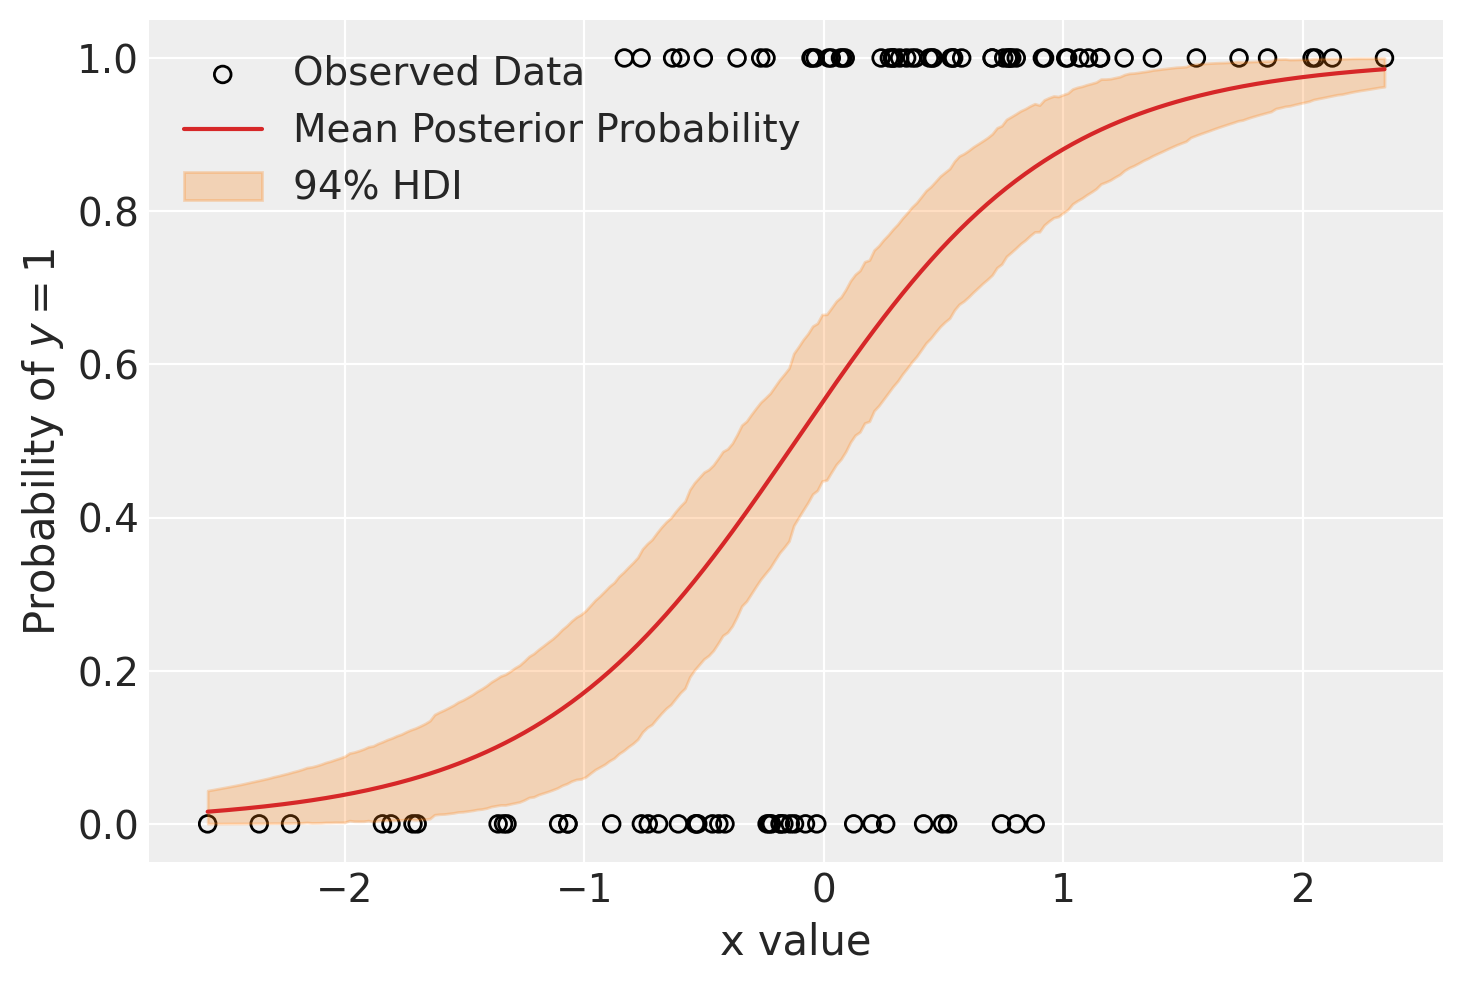

In [21]:
fig, ax = plt.subplots()
hdi = az.hdi(post_idata.posterior_predictive.p).p

ax.scatter(x, y, facecolor="none", edgecolor="k", label="Observed Data")
p_mean = post_idata.posterior_predictive.p.mean(dim=["chain", "draw"])
ax.plot(x_grid, p_mean, color="tab:red", label="Mean Posterior Probability")
ax.fill_between(x_grid, *hdi.values.T, color="tab:orange", alpha=0.25, label="94% HDI")
ax.legend()
ax.set(ylabel="Probability of $y=1$", xlabel="x value")
plt.show()

The same concept applied to a more complex model can be seen in the notebook {ref}`bayesian_neural_network_advi`.

## Applied example: height of toddlers as a function of age

This example is taken from Osvaldo Martin's book: [Bayesian Analysis with Python: Introduction to statistical modeling and probabilistic programming using PyMC and ArviZ, 2nd Edition](https://www.amazon.com/Bayesian-Analysis-Python-Introduction-probabilistic-ebook/dp/B07HHBCR9G) {cite:p}`martin2018bayesian`.

The World Health Organization and other health institutions around the world collect data
for newborns and toddlers and design [growth charts standards](http://www.who.int/childgrowth/en/). These charts are an essential component of the pediatric toolkit and also as a measure of the general well-being of
populations in order to formulate health policies, and plan interventions and
monitor their effectiveness.

An example of such data is the lengths (heights) of newborn / toddler girls as a function of age (in months):

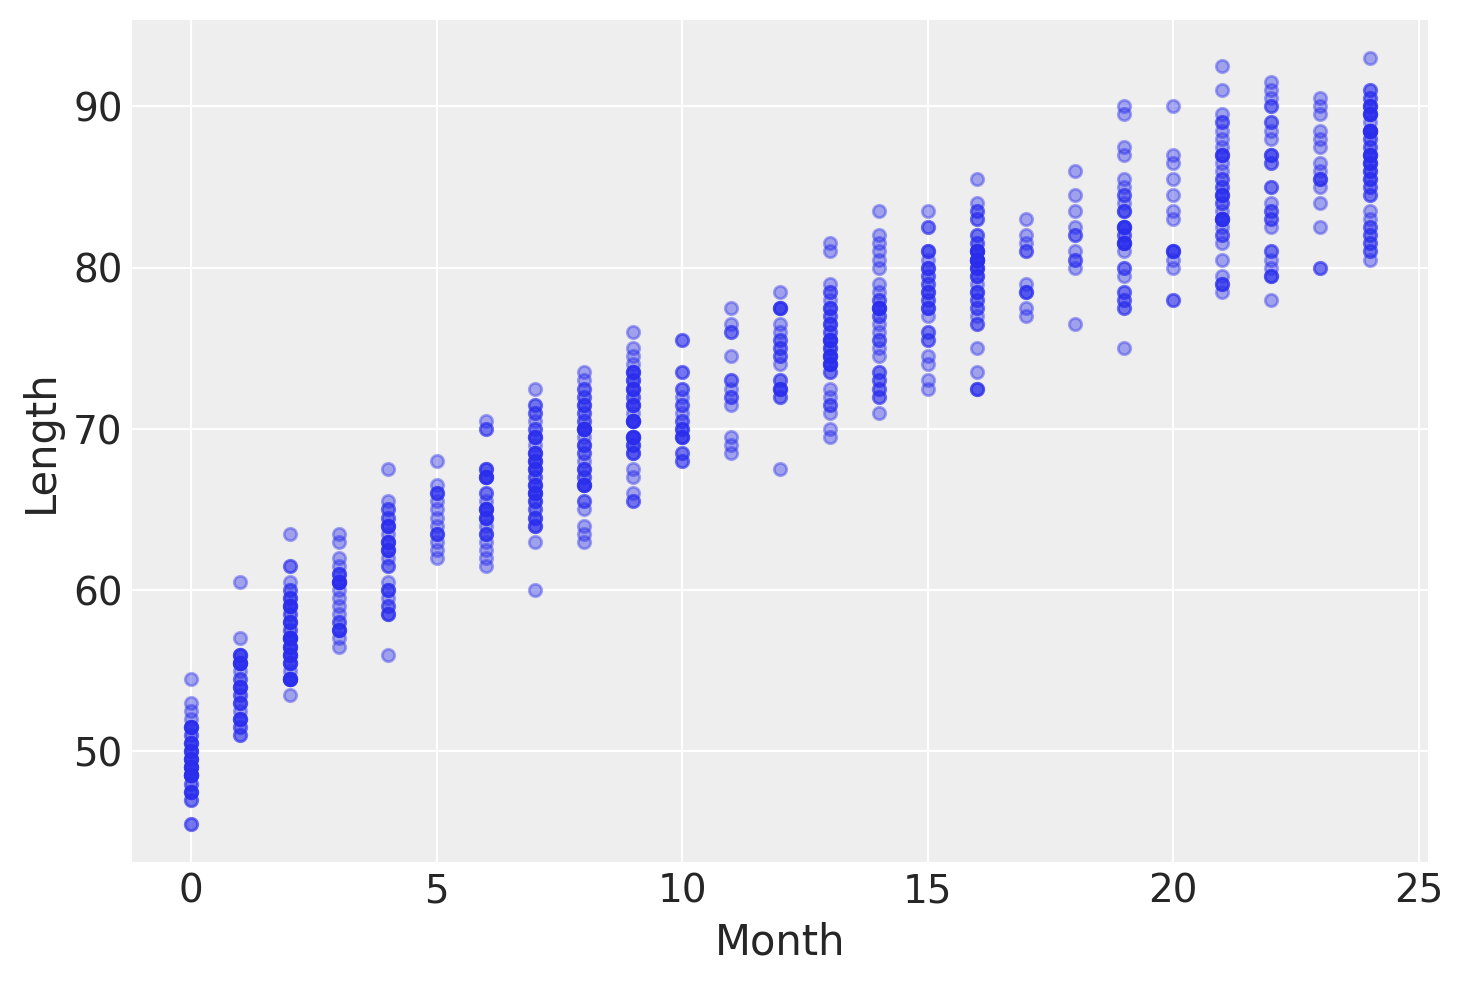

In [22]:
try:
    data = pd.read_csv("../data/babies.csv")
except FileNotFoundError:
    data = pd.read_csv(pm.get_data("babies.csv"))
data.plot.scatter("Month", "Length", alpha=0.4);

To model this data, we will need to mutate the `coords` because the index of the data needs to be changed according to the indexes of the testing dataset. Luckily, `coords` are always mutable, so we can mutate it during out-of-sample prediction.

In the example, we will be updating the coordinates of `obs_idx` to reflect the indexes of the testing dataset.

In [23]:
with pm.Model(
    coords={"obs_idx": np.arange(len(data)), "parameter": ["intercept", "slope"]}
) as model_babies:
    mean_params = pm.Normal("mean_params", sigma=10, dims=["parameter"])
    sigma_params = pm.Normal("sigma_params", sigma=10, dims=["parameter"])
    month = pm.Data("month", data.Month.values.astype(float), dims=["obs_idx"])

    mu = pm.Deterministic("mu", mean_params[0] + mean_params[1] * month**0.5, dims=["obs_idx"])
    sigma = pm.Deterministic("sigma", sigma_params[0] + sigma_params[1] * month, dims=["obs_idx"])

    length = pm.Normal("length", mu=mu, sigma=sigma, observed=data.Length, dims=["obs_idx"])

    idata_babies = pm.sample(random_seed=RANDOM_SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean_params, sigma_params]


/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


The following figure shows the result of our model. The expected length, $\mu$, is represented with a blue curve, and two semi-transparent orange bands represent the 60% and 94% highest posterior density intervals of posterior predictive length measurements:

In [24]:
with model_babies:
    pm.sample_posterior_predictive(idata_babies, extend_inferencedata=True, random_seed=RANDOM_SEED)

Sampling: [length]


/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

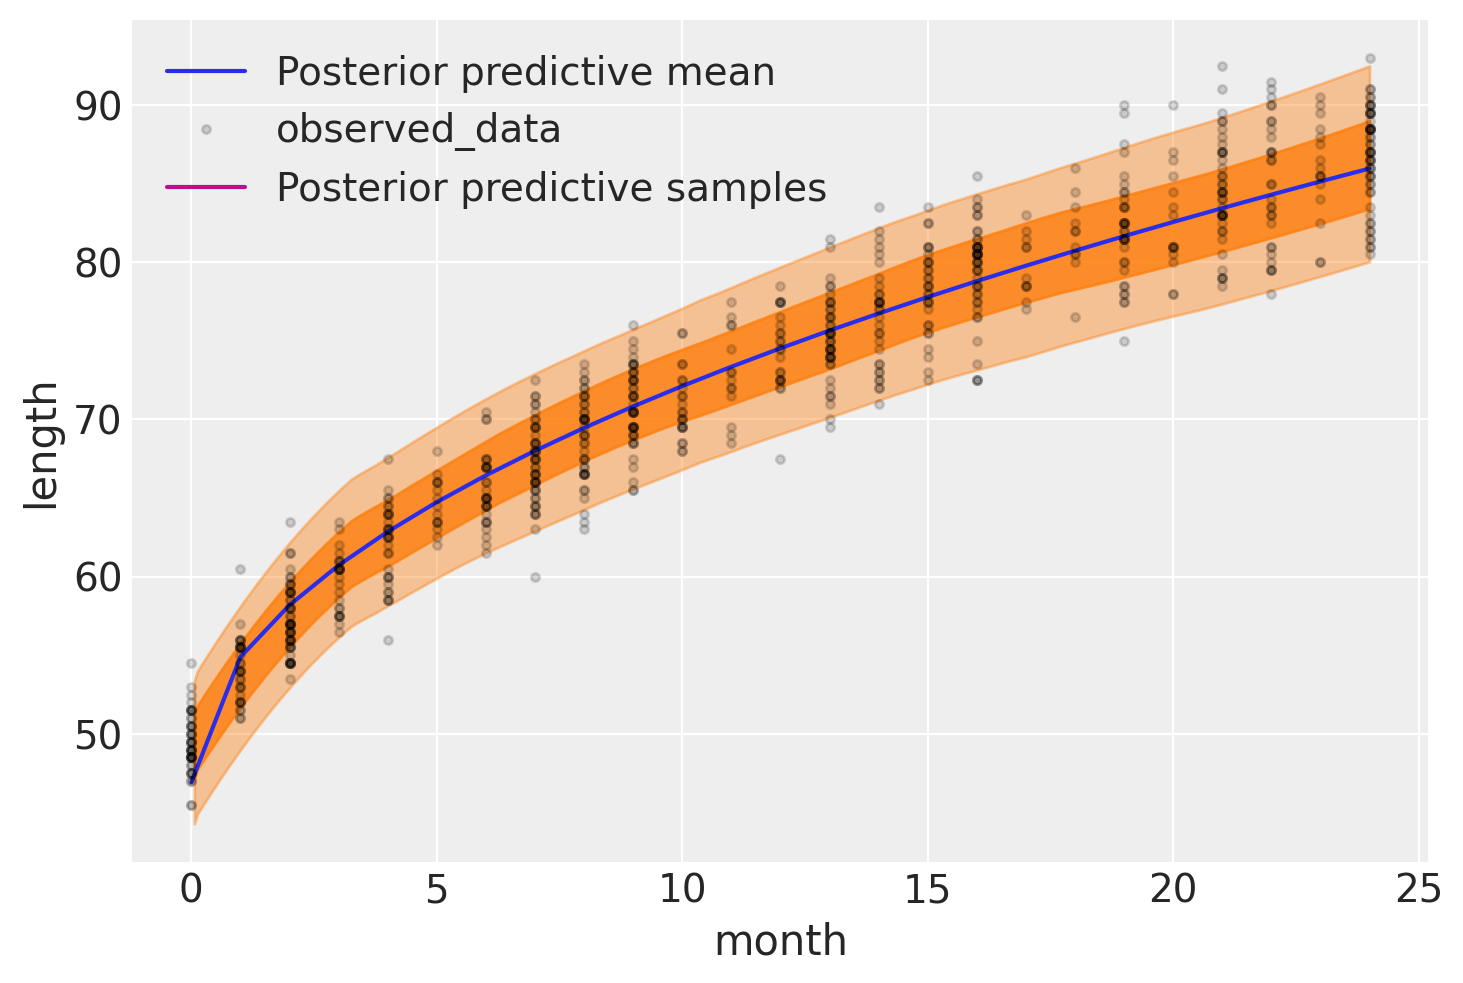

In [25]:
ax = az.plot_hdi(
    data.Month,
    idata_babies.posterior_predictive["length"],
    hdi_prob=0.6,
    fill_kwargs={"color": "tab:orange", "alpha": 0.8},
)
ax.plot(
    data.Month,
    idata_babies.posterior["mu"].mean(("chain", "draw")),
    label="Posterior predictive mean",
)
ax = az.plot_lm(
    idata=idata_babies,
    y="length",
    x="month",
    kind_pp="hdi",
    y_kwargs={"color": "k", "ms": 6, "alpha": 0.15},
    y_hat_fill_kwargs=dict(fill_kwargs={"color": "tab:orange", "alpha": 0.4}),
    axes=ax,
)

At the moment of writing Osvaldo's daughter is two weeks ($\approx 0.5$ months) old, and thus he wonders how her length compares to the growth chart we have just created. One way to answer this question is to ask the model for the distribution of the variable length for babies of 0.5 months. Using PyMC we can ask this questions with the function `sample_posterior_predictive` , as this will return samples of _Length_ conditioned on the obseved data and the estimated distribution of parameters, that is including uncertainties. 

The only problem is that by default this function will return predictions for _Length_ for the observed values of _Month_, and $0.5$ months (the value Osvaldo cares about) has not been observed, -- all measures are reported for integer months. The easier way to get predictions for non-observed values of _Month_ is to pass new values to the `Data` container we defined above in our model. To do that, we need to use `pm.set_data` and then we just have to sample from the posterior predictve distribution. We will also have to set `coords` for these new observations, which we are allowed to do in the `pm.set_data` function because we have set the `obs_idx` coord as mutable. 

Note that the actual value we pass for `obs_idx` is totally irrelevant *in this case*, so we give it a value of 0. What is important is that we update it to have the same length as the ages we want to do out-of-sample prediction for, and that each age has a unique index identifier.

In [26]:
ages_to_check = [0.5]
with model_babies:
    pm.set_data({"month": ages_to_check}, coords={"obs_idx": [0]})

    # Setting predictions=True will add a new "predictions" group to our idata. This lets us store the posterior,
    # posterior_predictive, and predictions all in the same object.
    idata_babies = pm.sample_posterior_predictive(
        idata_babies, extend_inferencedata=True, predictions=True, random_seed=RANDOM_SEED
    )

Sampling: [length]


/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Now we can plot the expected distribution of lengths for 2-week old babies and compute additional quantities -- for example the percentile of a child given her length. Here, let's imagine that the child we're interested in has a length of 51.5:

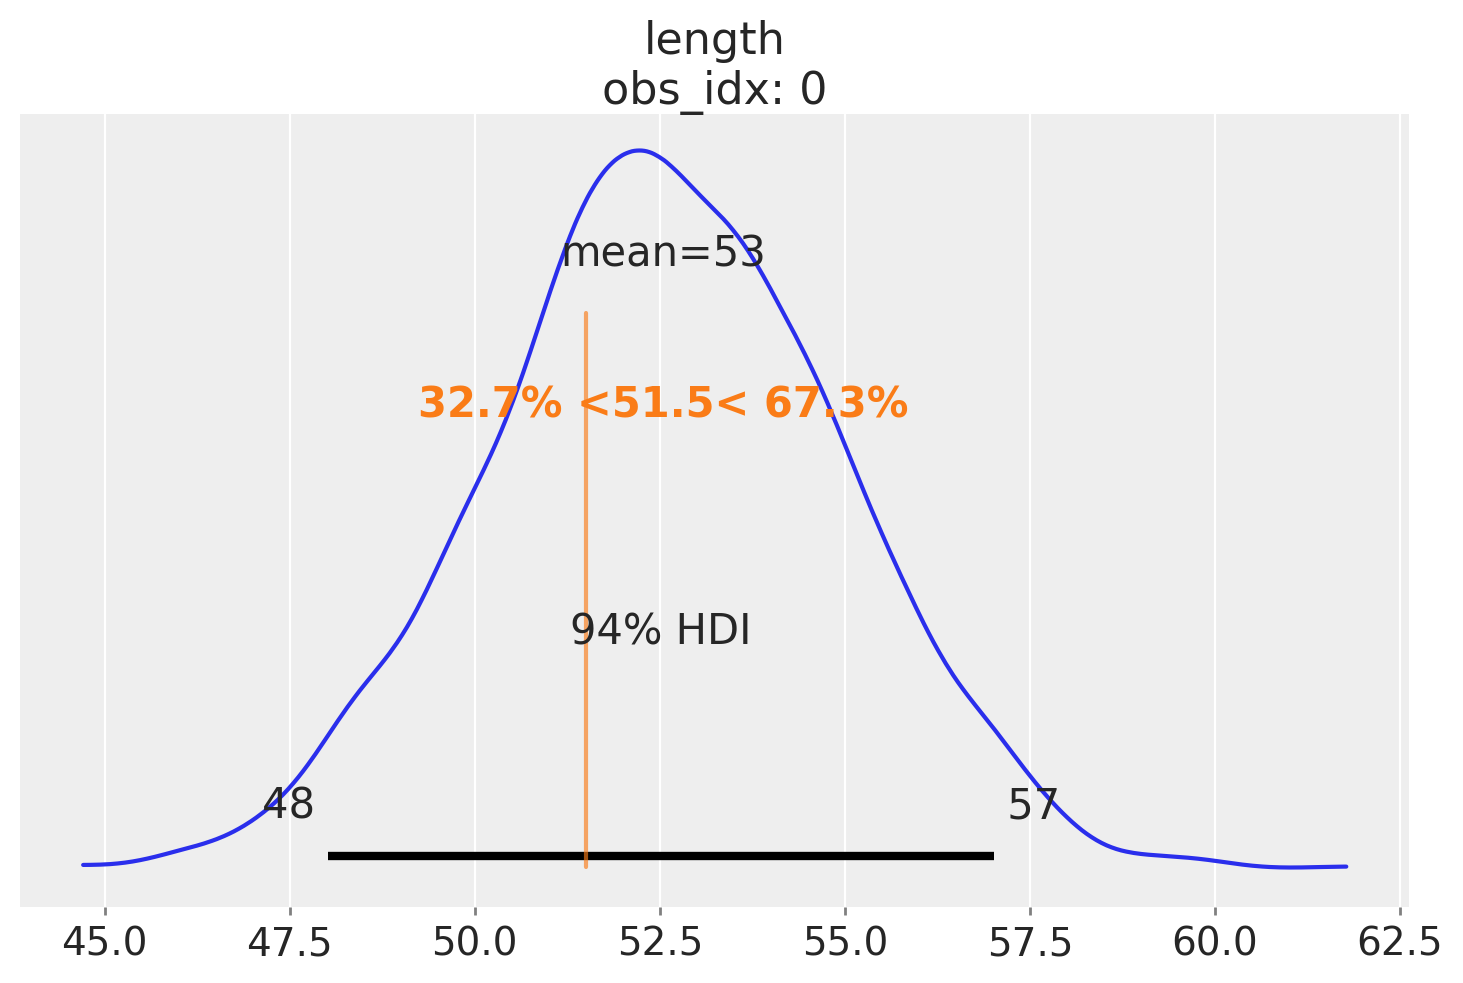

In [27]:
ref_length = 51.5

az.plot_posterior(
    idata_babies,
    group="predictions",
    ref_val={"length": [{"ref_val": ref_length}]},
    labeller=az.labels.DimCoordLabeller(),
);

## Watermark

In [28]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,xarray

Last updated: Tue Feb 25 2025

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.32.0

pytensor: 2.27.1
xarray  : 2025.1.2

pytensor  : 2.27.1
arviz     : 0.20.0
numpy     : 1.26.4
matplotlib: 3.10.0
pymc      : 5.20.1
pandas    : 2.2.3

Watermark: 2.5.0



:::{include} ../page_footer.md
:::